# Dublin Air Pollution
#### [ Programming for Data Analysis Project GMIT 2020 ]
<br>

<img align="left" width="340" src="http://airtoxenviro.com/wp-content/uploads/2015/05/Power-Plant-Clip-Art.png">

<br><br><br><br><br><br><br><br><br><br><br><br><br><br>
_Completed by:_ Olga Rozhdestvina (G00387844@gmit.ie)

___
<br>

## Table of Contents
* [Overview](#overview)
* [General Setup](#setup)
* [Original Data](#original_data)
* [Analysis of the Data Set](#analysis)
    * [Pollution](#pollutants)
    * [Wind](#wind)
    * [Correlation Between Variables](#correlation)
        * [Pollution vs Time](#pol_vs_time)
        * [Wind speed vs Time](#wind_vs_time)
        * [Pollution vs Wind Speed](#pol_vs_wind)
* [Distribution Fitting](#dist_fitting)
* [Data Simulation](#data_simulation)
* [Simulated Data Set](#new_ds)
* [Comparison of Simulated and Original data sets](#comparison)
    * [Visualization](#vis)
    * [T-test](#ttest)
    * [Entropy](#entropy)
* [Final Adjustments](#adj)

<br>

### Overview <a href="overview"></a>
___

<br>

Air pollution is a mixture of solid and gas particles in the air. Every year it causes approximately seven million premature deaths [1]. As air pollution levels have increased,so too there has been a growing interest in modelling the relationship between atmospheric concentration of pollutants and various meteorological conditions in the area studied. [2]

The Air Quality Index, or AQI, is used for measuring the real-time pollution. The higher it is, the greater the level of air pollution. AQI is based on measurement of:

* **NO2** - nitrogen dioxide, 
* **PM10** - particulate matter with a diameter of less than 2.5 micrometers,
* **PM2.5** - particulate matter with a diameter of less than 2.5 micrometers,
* **O3** - ozone,
* **SO2** - sulfur dioxide.

There are a number of meteorological factors that affect AQI. In my analysis, I will be looking at wind speed and direction. 

Variables measured for this project: _AQI_ variable is a non-negative integer, _NO2, PM10, PM2.5, O3, SO2, Wind_ are non-negative real numbers with one decimal place and _Wind Direction_ is a categorical variable with four possible values: west, north east, north, north west.

> [1] [WHO: Air Pollution](https://www.who.int/health-topics/air-pollution#:~:text=The%20combined%20effects%20of%20ambient,cancer%20and%20acute%20respiratory%20infections.)
<br>
[2] [Joanna A. Kaminska: Probabilistic Forecasting of Nitrogen Dioxide Concentrations at an Urban Road Intersection](https://www.researchgate.net/publication/328978359_Probabilistic_Forecasting_of_Nitrogen_Dioxide_Concentrations_at_an_Urban_Road_Intersection)

<br>

### General Setup  <a name="setup"></a>
___

<br>

In [1]:
# Dataframes.
import pandas as pd
# To register the converters
from pandas.plotting import register_matplotlib_converters

# Calculations and distributions.
import numpy as np

# Distribution fitting.
from scipy import stats

# Plotting.
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Register converters and inline plots.
register_matplotlib_converters()
%matplotlib inline

In [2]:
# Colour scheme and styles for plots.
sns.set_theme(palette="Set2", context="paper", font_scale=1.5)

# Better sized plots.
plt.rcParams['figure.figsize'] = (13, 9)

<br>

### Original Data  <a name="original_data"></a>
___

<br>

I have collected data on air pollution in Dublin for 07/12/2020 from [IQAir](https://www.iqair.com/) - the website of a Swiss air quality technology company. [3] Data on wind speed and direction was collected from [Met Eireann Forecast](https://www.met.ie/) [4]


> [3] [IQAir: Air quality in Dublin](https://www.iqair.com/us/ireland/leinster/dublin)
<br>
[4] [Met Eireann Forecast in Dublin City](https://www.met.ie/weather-forecast/dublin-city#forecasts)

In [3]:
# Create the date range for 24 hours.
rng = pd.date_range('12/07/2020', periods=24, freq='H')

In [4]:
# Original data.
raw_data = {'AQI': [84,74,74,72,72,72,72,72,71,72,72,73,80,74,74,74,74,74,74,76,72,76,68,67],
            'NO2': [32.1,29.7,28.5,26.9,26.1,25.8,26.5,27.3,30.9,41.1,52,55.1,58.3,52,41.7,42.6,41.9,38.7,43.1,37.5,32.4,28.7,27.2,20.6],
            'PM2.5': [28,23,23,22.1,22.2,22.1,22,21.9,21.8,22,22.2,22.4,25.9,23,23.1,23.2,23.1,23.1,22.9,24,22.3,24.1,20.1,19.7],
            'PM10': [36,33,28.1,21.2,21.5,19.8,17.1,16.4,15.1,16.6,21.2,28.6,31.1,25.7,25.5,24.4,30.9,25.9,30.9,32.8,30.7,26.6,21.3,18.4],
            'O3': [1,0.4,0.8,0.4,0.3,0.4,0.7,0.3,0,0.6,0.7,0,0.8,0.8,1.8,1.5,1.1,0.8,0.9,0.8,0.7,1.8,3,4.6],
            'SO2': [5,4.2,4.1,3.9,3.7,4.3,4.8,4.2,4.6,6.6,8.2,9.2,10.6,8.6,6.7,6.8,6.9,6,6.3,5,3.6,4.1,4.1,3.4],
            'Wind': [9,9,9,7,7,7,7,7,6,7,7,9,17,15,15,19,13,17,17,19,19,19,19,22],
            'Wind Direction': ['west','west','west','north west','north west','west','north west','north west','north west','north west','north east','north west','north','north','north west','north west','north west','north west','west','west','west','west','west','west']
           }


# Create a dataframe.
df = pd.DataFrame(raw_data, index=rng)

# Display the dataframe.
df

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind,Wind Direction
2020-12-07 00:00:00,84,32.1,28.0,36.0,1.0,5.0,9,west
2020-12-07 01:00:00,74,29.7,23.0,33.0,0.4,4.2,9,west
2020-12-07 02:00:00,74,28.5,23.0,28.1,0.8,4.1,9,west
2020-12-07 03:00:00,72,26.9,22.1,21.2,0.4,3.9,7,north west
2020-12-07 04:00:00,72,26.1,22.2,21.5,0.3,3.7,7,north west
2020-12-07 05:00:00,72,25.8,22.1,19.8,0.4,4.3,7,west
2020-12-07 06:00:00,72,26.5,22.0,17.1,0.7,4.8,7,north west
2020-12-07 07:00:00,72,27.3,21.9,16.4,0.3,4.2,7,north west
2020-12-07 08:00:00,71,30.9,21.8,15.1,0.0,4.6,6,north west
2020-12-07 09:00:00,72,41.1,22.0,16.6,0.6,6.6,7,north west


<br>

### Analysis of the data set <a name="analysis"></a>
___

Prior to visualizing our data, let us examine the descriptive statsitics calculated from it.

In [5]:
df.describe()

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind
count,24.000000,24.000000,24.00000,24.000000,24.000000,24.000000,24.000000
mean,73.458333,36.112500,22.80000,24.950000,1.008333,5.620833,12.583333
std,3.387691,10.507609,1.64766,6.052308,1.004302,1.975498,5.428721
min,67.000000,20.600000,19.70000,15.100000,0.000000,3.400000,6.000000
25%,72.000000,27.275000,22.07500,20.850000,0.400000,4.100000,7.000000
50%,73.500000,32.250000,22.65000,25.600000,0.800000,4.900000,11.000000
75%,74.000000,42.075000,23.10000,30.750000,1.025000,6.725000,17.500000
max,84.000000,58.300000,28.00000,36.000000,4.600000,10.600000,22.000000


It is clear from the table above that the highest concentration belongs to _NO2_.

<br>

#### Pollution <a name="pollutants"></a> 

<br>

First we should plot the pollution related data on that day. [5]

> [5] [Stack Overflow: Pandas: Sort column by maximum values](https://stackoverflow.com/questions/40111161/pandas-sort-column-by-maximum-values)

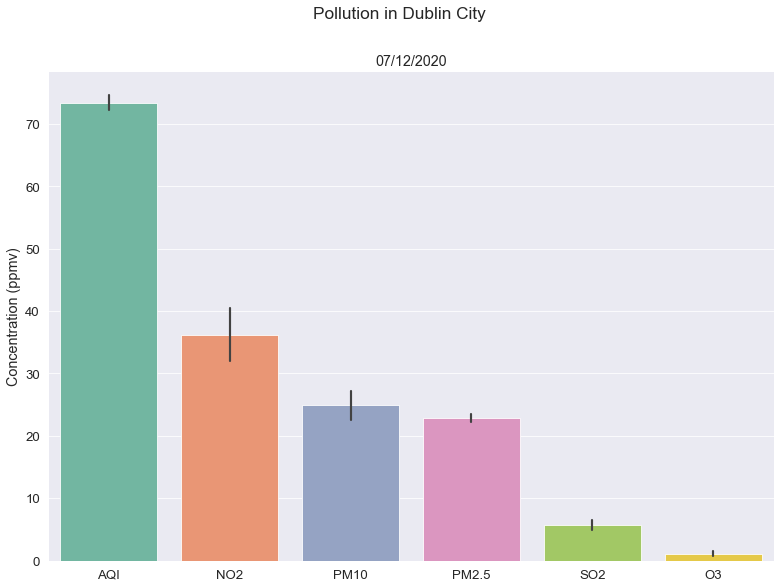

In [6]:
# Separate pollution values.
pollution = df[['AQI','NO2','PM2.5','PM10','O3','SO2']]

# Sort them by maximum value.
sorted_pol = pollution.loc[:, pollution.max().sort_values(ascending=False).index]

# Create a figure and axis.
fig, ax = plt.subplots()

# Set titles and y label.
fig.suptitle("Pollution in Dublin City")
ax.set_ylabel("Concentration (ppmv)")

# Plot the data ordered by maximum and set a small title.
sns.barplot(data=pollution, order=list(sorted_pol), ax=ax).set_title("07/12/2020")

# Show plot.
plt.show()

Now, let's look at the pollutant concentration levels in percentages. [6] [7]

> [6] [GeeksforGeeks: How to get column names in Pandas dataframe](https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/)
<br>
[7] [Matplotlib: Basic pie chart](https://matplotlib.org/3.3.3/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py)

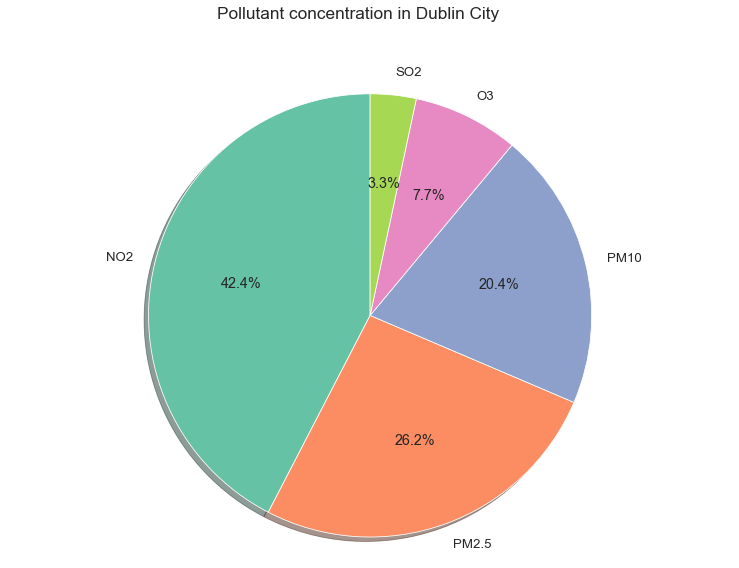

In [7]:
# Calculate maximum values of each pollutant and set as pie sizes, set pollutant names as labels
sizes = [df['NO2'].max(), df['PM10'].max(), df['PM2.5'].max(), df['SO2'].max(), df['O3'].max()]
labels = [col for col in pollution.columns][1:]

# Create a figure and axis, set a title.
fig, ax = plt.subplots()
fig.suptitle("Pollutant concentration in Dublin City")

# Build a pie plot.
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
# Equal aspect ratio ensures that pie is drawn as a circle.
ax.axis('equal') 

# Show the plot.
plt.show()

<br>

The above plots confirm that the primary pollutant in Dublin is _NO2_. The next in line are _PM10_ and _PM2.5_ , whereas _SO2_ is fairly low and _O3_ is almost non-existent.

Next we should view how each pollutant and AQI is distributed. [8]

> [8] [Stack Overflow: Matplotlib subplots_adjust hspace so titles and xlabels don't overlap?
](https://stackoverflow.com/questions/2418125/matplotlib-subplots-adjust-hspace-so-titles-and-xlabels-dont-overlap)

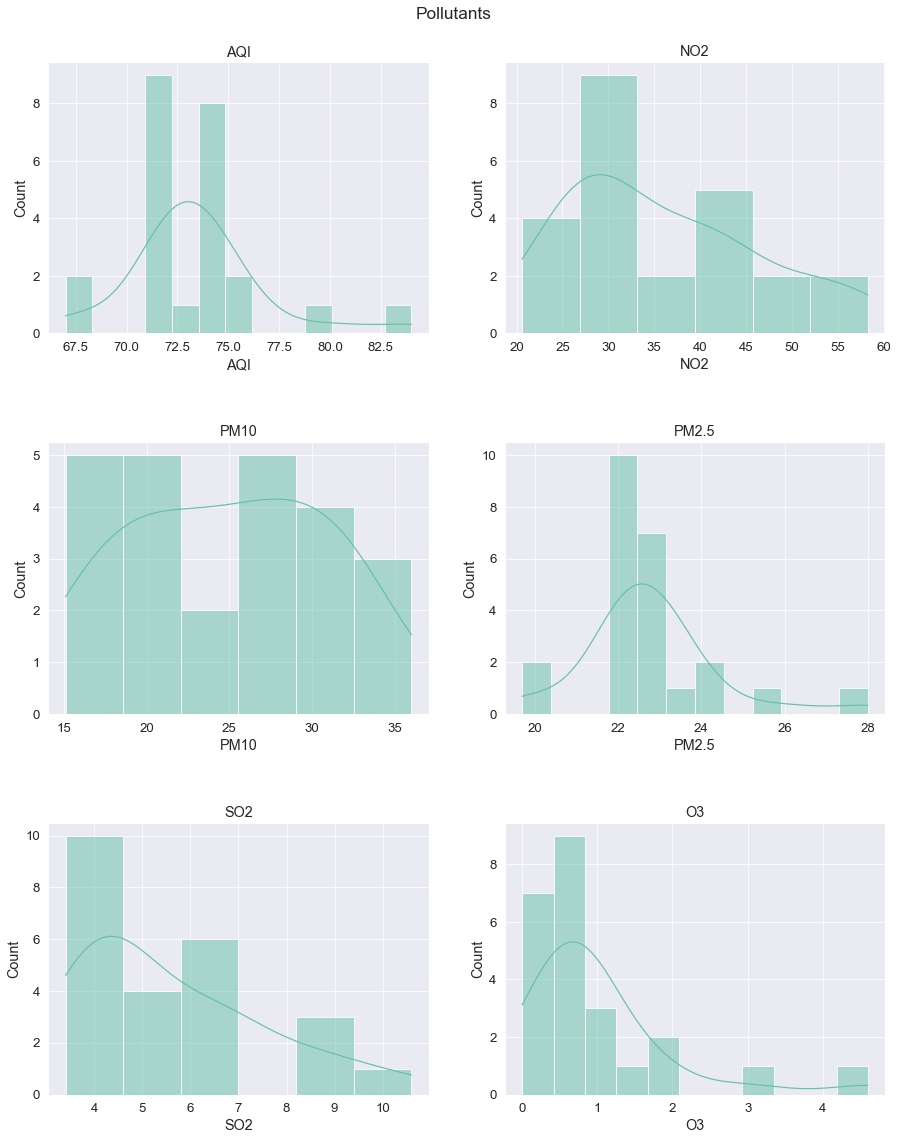

In [8]:
# Create a figure and a set of subplots 3x2 and change plot size.
fig, [[ax1, ax2],[ax3,ax4],[ax5,ax6]] = plt.subplots(3,2, figsize=(15,19))

# Set a title.
fig.suptitle("Pollutants", y=0.92)

# Adjust subplots so the title don't overlap.
plt.subplots_adjust(hspace=0.4)

def hist(data, ax):
    """ Fuction to build a histogram"""
    # Plot data.
    sns.histplot(df[data], kde=True, ax=ax)
    # Set title.
    ax.set_title(f"{data}")

# Plot the data.
hist('AQI',ax1)
hist('NO2',ax2)
hist('PM10',ax3)
hist('PM2.5',ax4)
hist('SO2',ax5)
hist('O3',ax6)

# Show the plots.
plt.show()

<br>

From the historgrams above, the data does not appear to attain normal distribution and it is difficult to say which type of distribution will fit any of the variables with any degree of certainty.

<br>

#### Wind <a name="wind"></a> 

<br>

Following the same process, we can build plots for Wind related data.

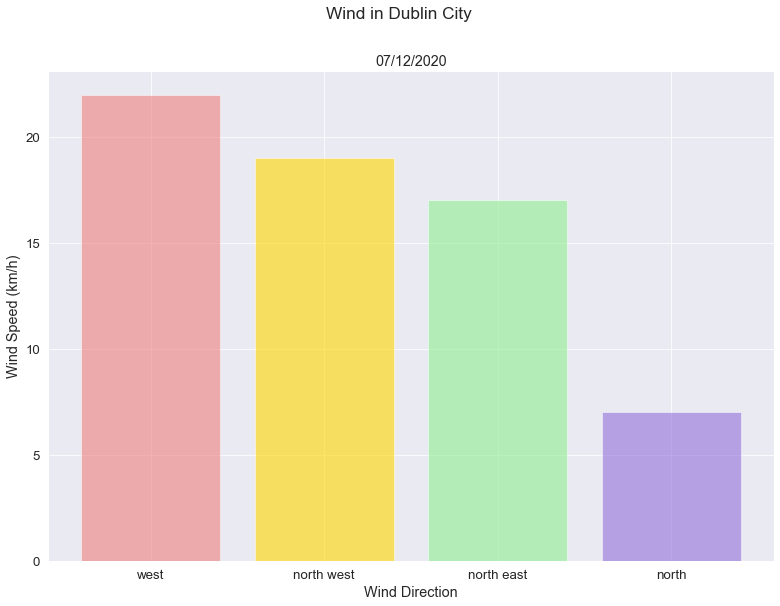

In [9]:
# Separate wind related values.
wind = df[['Wind', "Wind Direction"]]

# Select unique values.
labels = wind["Wind Direction"].unique()

# Calculate maximum speed for each wind drection
west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'west']).max()
north_west = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north west']).max()
north_east = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north east']).max()
north = (wind.loc[wind.loc[:, 'Wind Direction'] == 'north']).max()

# Create an array from the calculations
values = [west[0], north_west[0], north_east[0], north[0]]

# Sort in a descending manner.
values.sort(reverse=True)

# Create a figure and axis
fig, ax = plt.subplots()

# Set titles and axis labels
fig.suptitle("Wind in Dublin City")
ax.set_title("07/12/2020")
ax.set_xlabel("Wind Direction")
ax.set_ylabel("Wind Speed (km/h)")

# Plot data.
ax.bar(labels, values, color=['lightcoral', 'gold', 'lightgreen', 'mediumpurple'], alpha=.6)

# Show plot.
plt.show()

<br>

The plot shows that the strongest wind during 7th December was from the west.

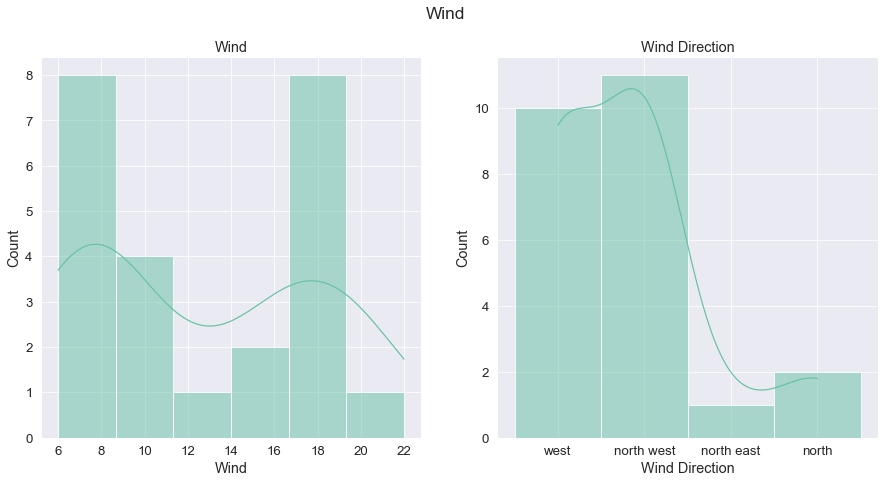

In [10]:
# Create a figure and a set of subplots 1x2.
fig, [ax1,ax2] = plt.subplots(1,2, figsize=(15, 7))

# Set a title.
fig.suptitle("Wind")

# Plot wind data.
hist("Wind",ax1)
hist("Wind Direction",ax2)

# Show the plot.
plt.show()

<br>

Once again the data plotted above doesn't appear to be normally distributed and without fitting a distribution it is hard to tell which type will be the best fit.


<br>

#### Correlation Between Variables <a name="correlation"></a> 

<br>

Next, we will explore the correlation between pollutants, time of day and wind speed. [9]

> [9] [Stack Overflow: how to get ticks every hour?](https://stackoverflow.com/questions/48790378/how-to-get-ticks-every-hour) 


<br>

##### Pollution vs Time  <a name="pol_vs_time"></a> 

<br>

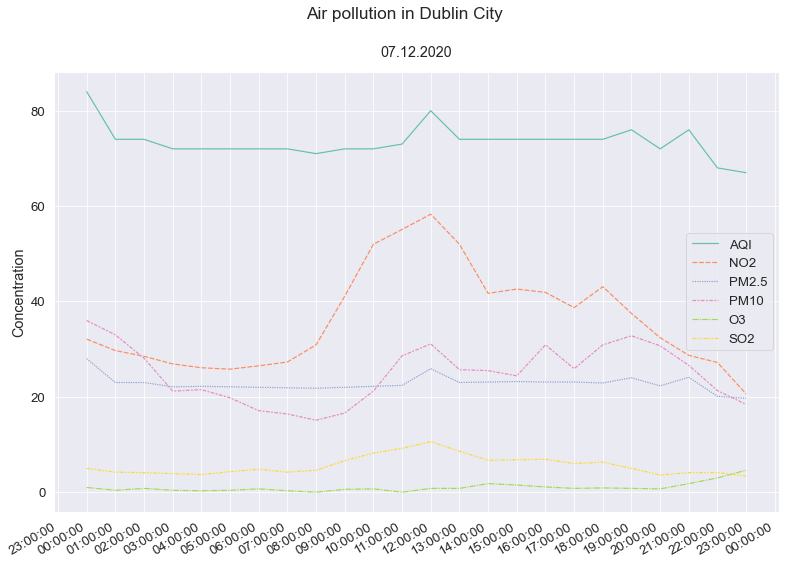

In [11]:
def lineplot(data, suptitle, label):
    """ Building lineplot function """
    
    # Create a figure and axis.
    fig, ax = plt.subplots()    
    # Set a title and a label for y axis.
    fig.suptitle(suptitle)
    ax.set_ylabel(label)
    
    # Plot data.
    sns.lineplot(data=data,ax=ax).set_title("07.12.2020", y=1.02)
    
    # Make the x axis display well.
    hours = mdates.HourLocator(interval = 1)
    h_fmt = mdates.DateFormatter('%H:%M:%S')
    # Tick ax axis.
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(h_fmt)
    # Format.
    fig.autofmt_xdate()
    
    # Show the plot.
    plt.show()

# Plot pollution data.
lineplot(pollution, "Air pollution in Dublin City", "Concentration")   

<br>

The plot depicts the relationship between the concentration of NO2, PM10 and SO2 and time of the day: it starts rising from 7-8am, reaches its peack at 12pm and then again at 6-7pm before falling after 7pm. 
One possible explanation for this trend is that main pollutants in Dublin originate in automobiles, and thus the pollution concentration rises and falls with traffic.

Moreover, we can see that PM10 and PM2.5 were high before 1-2am which could be explained by a number of factors, such as change in atmospheric conditions, energy and electricity consumption etc. [10]


> [10] [Springer Link: Influence of the atmospheric conditions on PM10 concentrations in Poznań, Poland](https://link.springer.com/article/10.1007/s10874-016-9345-5)

<br>

##### Wind speed vs Time  <a name="wind_vs_time"></a> 

<br>

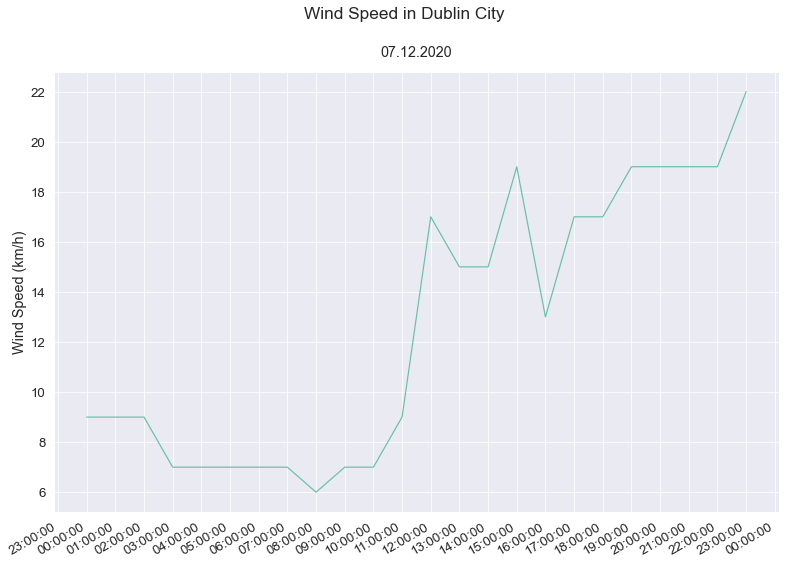

In [12]:
# Plot wind data.
lineplot(df["Wind"], "Wind Speed in Dublin City", "Wind Speed (km/h)")

<br>

The graph shows that between midnight and 11am wind speeds were relatively low (below 10 km/h). From 11am wind speed soared, with only a few drops until it reached its peak at 11pm. 

<br>

##### Pollution vs Wind Speed <a name="pol_vs_wind"></a>

<br>

Now that we have looked at relashionship between time and pollutants, we turn to investigate correlation between pollutant variables and wind speed. [11]

> [11] [Real Python: NumPy, SciPy, and Pandas: Correlation With Python](https://realpython.com/numpy-scipy-pandas-correlation-python/#example-scipy-correlation-calculation)

<br>

* __NO2__

In [13]:
def correlation(pollutant, var):
    """ Correlation calculation """
    # Pearson’s r.
    cf1, p1 = stats.pearsonr(df[pollutant], df[var])
    # Spearman’s rho.
    cf2, p2 = stats.spearmanr(df[pollutant], df[var])
    # Kendall’s tau.
    cf3, p3 = stats.kendalltau(df[pollutant], df[var])
    # print correlation coefficients and p-values to two decimal points.
    print(f"Pearson’s r: {cf1:.2f}, p-value: {p1:.2f}")
    print(f"Spearman’s rho: {cf2:.2f}, p-value: {p2:.2f}")
    print(f"Kendall’s tau: {cf3:.2f}, p-value: {p3:.2f}")

# Calculate correlation between NO2 and Wind Speed.
correlation("NO2", "Wind")

Pearson’s r: nan, p-value: nan
Spearman’s rho: 0.19, p-value: 0.38
Kendall’s tau: 0.13, p-value: 0.39


In these results, all three coefficients indicate a weak positive correlation between NO2 and wind speed. However, they are not statistically significant since p-value in all three cases is above 0.05 [12] [13]

> [12] [Statistical Help: P Values](https://www.statsdirect.com/help/basics/p_values.htm)
<br>
[13] [Minitab Express Support: Interpret the key results for Correlation](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward)

<br>

* __PM10__

In [14]:
# Calculate correlation between PM10 and Wind Speed.
correlation("PM10", "Wind")

Pearson’s r: 0.36, p-value: 0.08
Spearman’s rho: 0.47, p-value: 0.02
Kendall’s tau: 0.33, p-value: 0.03


Here we can see that Spearman’s and Kendall’s correlation coefficients are statistically significant (with p-value is below 0.05) and both indicate a moderate positive correlation between PM10 and wind speed. [14] [15]

> [14] [Stack Overflow: How to Scatter plot or heatmap spearman's correlation in python?](https://stackoverflow.com/questions/62201732/how-to-scatter-plot-or-heatmap-spearmans-correlation-in-python)
<br>
[15] [Stack Exchange: seaborn heatmap not displaying correctly](https://datascience.stackexchange.com/questions/57245/seaborn-heatmap-not-displaying-correctly)

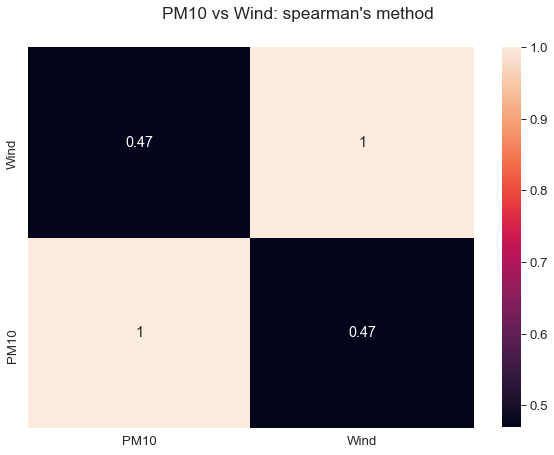

In [15]:
def plot_corr(pollutant, var, method):
    """ Plot correlation heatmap"""
    
    # Create a figure and axis.
    fig, ax = plt.subplots(figsize=(10, 7))
    # Create a Dataframe for plotting.
    df_corr = pd.DataFrame({pollutant: df[pollutant], var: df[var]})
    # Calculate correlation with pandas.
    corr = df_corr.corr(method = method)
    
    # Build a plot.
    sns.heatmap(corr, annot=True, ax=ax)
    
    # Set a title.
    fig.suptitle(f"{pollutant} vs {var}: {method}'s method", y=0.96)
    # Set y limits so the annotations are shown correctly.
    plt.ylim(0,2)
    
    # Show the plot.
    plt.show()
    

# Plot PM10 vs Wind with Spearman’s method.
plot_corr("PM10", "Wind", "spearman")

<br>

* __PM2.5__

In [16]:
# Calculate correlation between PM2.5 and Wind Speed.
correlation("PM2.5", "Wind")

Pearson’s r: 0.01, p-value: 0.96
Spearman’s rho: 0.39, p-value: 0.06
Kendall’s tau: 0.37, p-value: 0.02


In the case of PM2.5, only Kendall's tau is statistically significant and indicate a moderate positive correlation with wind speed.

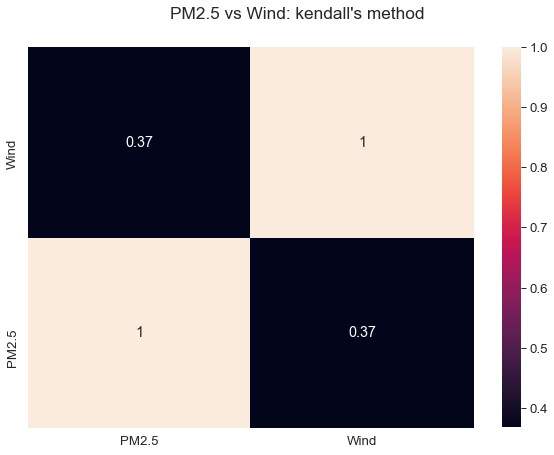

In [17]:
# Plot PM2.5 vs Wind with Kendall’s method.
plot_corr("PM2.5", "Wind", "kendall")

<br>

* __SO2__

In [18]:
# Calculate correlation between SO2 and Wind Speed.
correlation("SO2", "Wind")

Pearson’s r: 0.06, p-value: 0.79
Spearman’s rho: -0.04, p-value: 0.84
Kendall’s tau: -0.04, p-value: 0.82


None of the above results are statistically significant.

<br>

* __O3__

In [19]:
# Calculate correlation between O3 and Wind Speed.
correlation("O3", "Wind")

Pearson’s r: 0.67, p-value: 0.00
Spearman’s rho: 0.77, p-value: 0.00
Kendall’s tau: 0.62, p-value: 0.00


All three coefficients show a strong positive correlation between O3 and wind speed and since the p-value in all three cases is 0.00 the results are highly significant. 

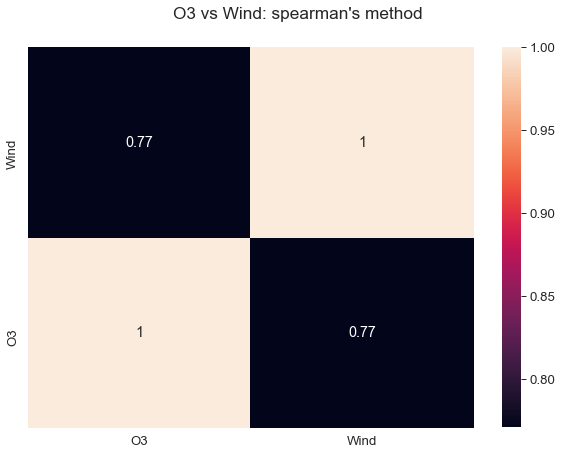

In [20]:
# Plot O3 vs Wind with Spearman’s method.
plot_corr("O3", "Wind", "spearman")

<br>

* __AQI__

Since only PM10, PM2.5 and O3 are positively correlated with wind speed and AQI is derived from pollutant variables, it is logical to assume that AQI will show a weak or moderate positive correlation with wind speed. Let's see if our assumptions are valid.

In [21]:
# Calculate correlation between AQI and Wind Speed.
correlation("AQI", "Wind")

Pearson’s r: 0.00, p-value: 0.99
Spearman’s rho: 0.33, p-value: 0.12
Kendall’s tau: 0.34, p-value: 0.04


As expected, in these results we have an indicator of a moderate positive correlation between the variables. However, Kendall’s tau arrives at statistical significance.

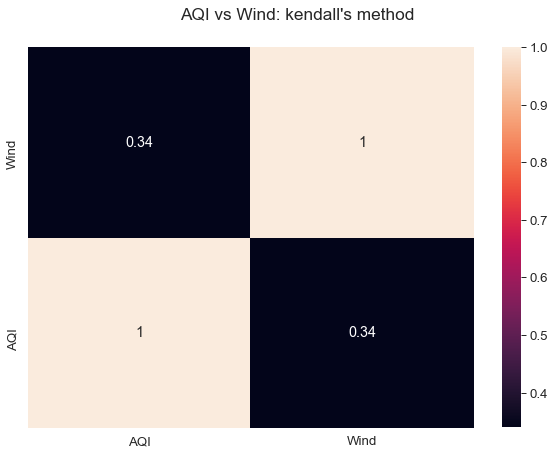

In [22]:
# Plot AQI vs Wind with Kendall’s method.
plot_corr("AQI", "Wind", "kendall")

<br>

### Distribution Fitting <a name=" dist_fitting"></a>
___

<br>

In fitting data on air pollution, there are many acceptable distribution models depending on the areas of study. For example, according to the International Journal of Engineering & Technology, among the most used distributions are: 
* gamma, 
* lognormal,
* weibull,
* beta,
* gumble.  [16]

However, this pertains to only a single source. In order to find which distribution fits our data best, we should evaluate the list of available distributions and then perform the test _The Goodness of Fit_. Below I will apply a widely used option _Kolmogorov–Smirnov test_. [17] [18] 

> [16] [International Journal of Engineering & Technology: Fitting Statistical Distribution on Air Pollution: An Overview](https://www.researchgate.net/publication/329267591_Fitting_Statistical_Distribution_on_Air_Pollution_An_Overview)
<br>
[17] [Medium: Distribution Fitting with Python SciPy](https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed)
<br>
[18] [Stack OVerflow: Distribution Fitting with Sum of Square Error (SSE)](https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python?lq=1)

In [23]:
def fit_dist(data):
    
    """ Fitting distributions function. 
        Performs K-S test and sorts results by lowest stats 
    """
    # List of 87 distribution available on Scipy.
    list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

    # Create an empty list.
    results = []

    # Loop through each distribution.
    for i in list_of_dists:
        dist = getattr(stats, i)
        # Fit it to the data.
        param = dist.fit(df[data])
        # Perform Kolmogorov–Smirnov test.
        a = stats.kstest(df[data], i, args=param)
        # Append results to the list.
        results.append((i,a[0],a[1]))

    # Sort results by the lowest statistic.
    results.sort(key=lambda x:float(x[2]), reverse=True)
    # Return only first 5 results.
    for j in results[:5]:
        # Print results.
        print(f"{j[0]}: statistic={j[1]}, pvalue={j[2]}")

In [24]:
def make_pdf(dist, params, size=1000):
    """Generate distributions's Probability Distribution Function """
    # Separate parts of parameters.
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get start and end points of distribution.
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas series.
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [25]:
def plot_data_with_pdf_fitted(data, dist):
    """Plot generation """
    # Fit distribution.
    params = dist.fit(df[data])
    
    # Call the function to make PDF
    pdf = make_pdf(dist, params)
    
    # Plot it
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    
    # Plot the data on the same axis.
    df[data].plot(kind='hist', density=True, title=data, alpha=0.5, label='Data', legend=True, ax=ax)
    
    # Show the plot.
    plt.show()

<br>

* __AQI__ 

In [26]:
%%capture --no-stdout

# Fit distributions to AQI.
fit_dist("AQI")

johnsonsu: statistic=0.18763881490250822, pvalue=0.32498944003741803
hypsecant: statistic=0.18963645012427643, pvalue=0.3130713043201745
loglaplace: statistic=0.18993290789719824, pvalue=0.31132848548659586
foldcauchy: statistic=0.1951248865529729, pvalue=0.281889074912843
cauchy: statistic=0.197972276142918, pvalue=0.2666099892945063


We can see that __laplace__ distribution will fit AQI data best. Let's import the distribution and then build a plot.

In [27]:
# Import laplace distribution.
from scipy.stats import laplace

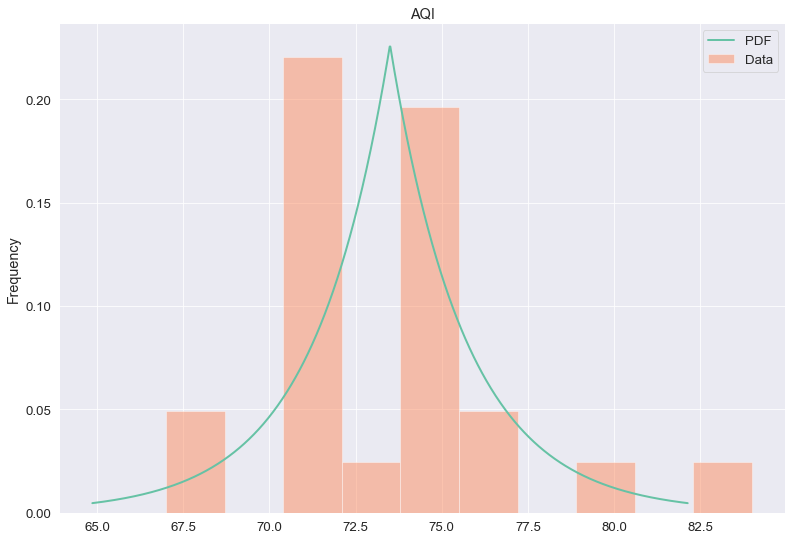

In [28]:
# Plot AQI with laplace distribution fitted.
plot_data_with_pdf_fitted("AQI", laplace)

<br>

* __NO2__ 

In [29]:
%%capture --no-stdout

# Fit distributions to NO2.
fit_dist("NO2")

pearson3: statistic=0.11006390814551326, pvalue=0.9027931699865703
chi2: statistic=0.11006421114138942, pvalue=0.9027914694459913
gamma: statistic=0.11006468221121257, pvalue=0.9027888255742391
erlang: statistic=0.11006485134136934, pvalue=0.902787876325263
recipinvgauss: statistic=0.11601677955935441, pvalue=0.8666799409906573


For NO2 the best fitting distribution is __pearson3__.

In [30]:
# Import pearson3 distribution.
from scipy.stats import pearson3

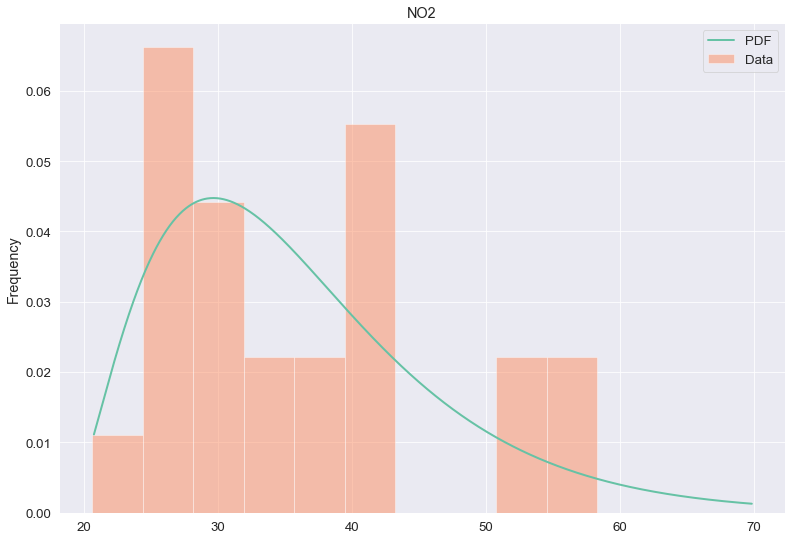

In [31]:
# Plot NO2 with pearson3 distribution fitted.
plot_data_with_pdf_fitted("NO2", pearson3)

<br>

* __PM10__ 

In [32]:
%%capture --no-stdout

# Fit distributions to PM10.
fit_dist("PM10")

johnsonsb: statistic=0.09105533900868285, pvalue=0.9779583351046626
gausshyper: statistic=0.09302889934088848, pvalue=0.973120610987277
beta: statistic=0.1035661252634218, pvalue=0.9357110786520266
mielke: statistic=nan, pvalue=nan
uniform: statistic=0.11044657097288674, pvalue=0.900633770329969


In [33]:
# Import johnsonsb distribution.
from scipy.stats import johnsonsb

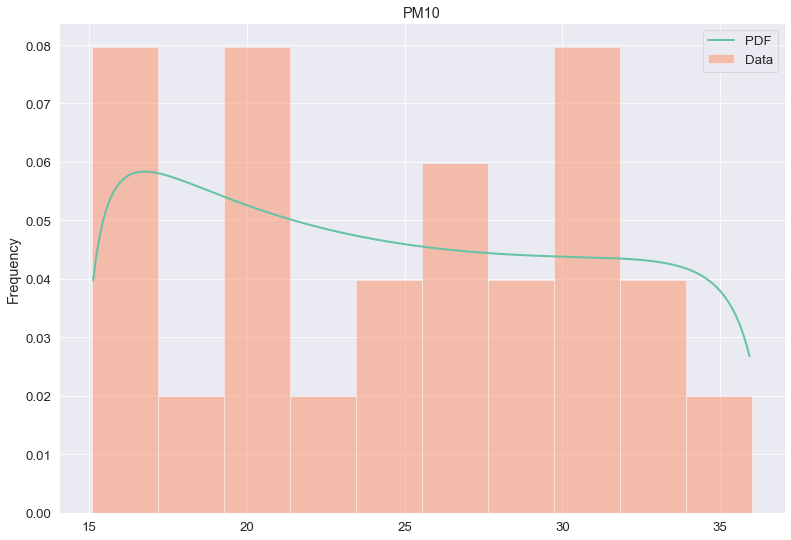

In [34]:
# Plot PM10 with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("PM10", johnsonsb)

<br>

* __PM2.5__ 

In [35]:
%%capture --no-stdout

# Fit distributions to PM2.5.
fit_dist("PM2.5")

laplace: statistic=0.14203432336984834, pvalue=0.6664904051237146
johnsonsu: statistic=0.1484896691755866, pvalue=0.6127555123904675
dweibull: statistic=0.15195030567570417, pvalue=0.5841939047304081
hypsecant: statistic=0.15195934006760087, pvalue=0.5841197408225358
foldcauchy: statistic=0.15610214243695786, pvalue=0.5503938801545367


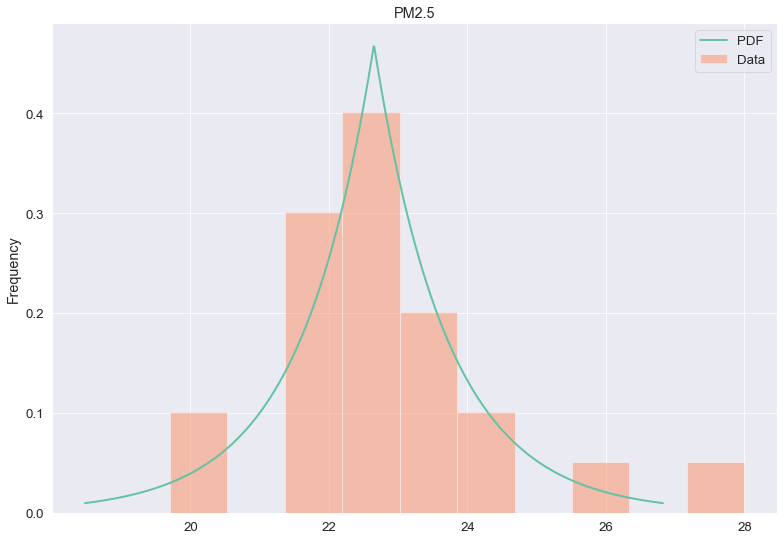

In [36]:
# Plot PM2.5 with laplace distribution fitted.
plot_data_with_pdf_fitted("PM2.5", laplace)

<br>

* __SO2__

In [37]:
%%capture --no-stdout

# Fit distributions to SO2.
fit_dist("SO2")

johnsonsb: statistic=0.10194551012266237, pvalue=0.942767708138756
lomax: statistic=0.10641180753942803, pvalue=0.922188037957963
expon: statistic=0.10652674009879692, pvalue=0.9216120654990875
exponnorm: statistic=0.10717876478344746, pvalue=0.9183014696654369
powerlognorm: statistic=0.11466944979525151, pvalue=0.8753058656714163


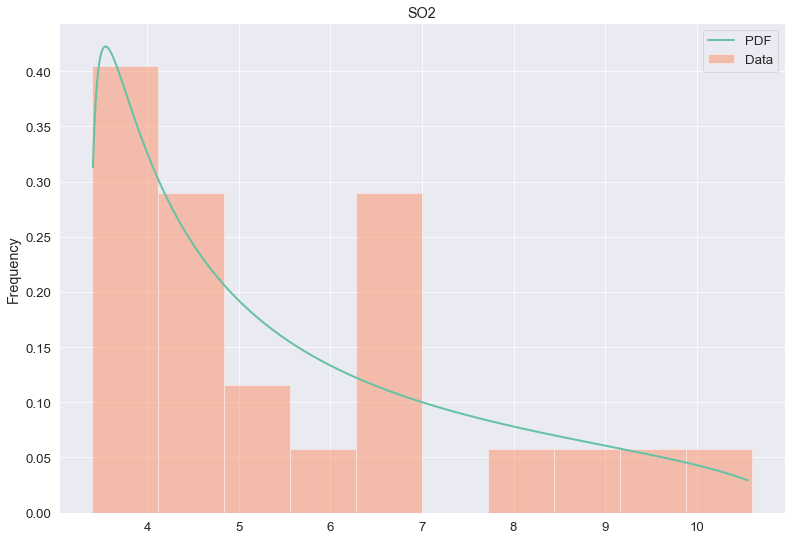

In [38]:
# Plot SO2 with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("SO2", johnsonsb)

<br>

* __O3__

In [39]:
%%capture --no-stdout

# Fit distributions to O3.
fit_dist("O3")

johnsonsu: statistic=0.12959299579073374, pvalue=0.7681184285005445
burr12: statistic=0.13028551739783517, pvalue=0.7626459543218433
nct: statistic=0.13128755837776368, pvalue=0.7546733803564891
foldcauchy: statistic=0.13165209561000235, pvalue=0.7517580113699818
fisk: statistic=0.13280729715523304, pvalue=0.7424704332640414


In [40]:
# Import johnsonsu distribution.
from scipy.stats import johnsonsu

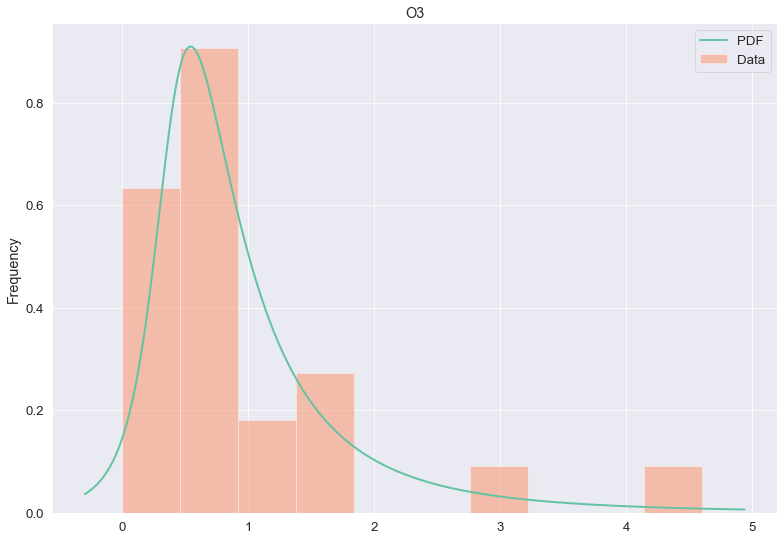

In [41]:
# Plot O3 with johnsonsu distribution fitted.
plot_data_with_pdf_fitted("O3", johnsonsu)

<br>

* __Wind Speed__

In [42]:
%%capture --no-stdout

# Fit distributions to Wind.
fit_dist("Wind")

johnsonsb: statistic=0.16838867342837419, pvalue=0.45497191291774763
dweibull: statistic=0.1690128430985166, pvalue=0.45035209992430436
mielke: statistic=nan, pvalue=nan
powerlaw: statistic=0.17054327497168503, pvalue=0.43913038603719157
nakagami: statistic=0.1744468553474331, pvalue=0.41121504766672146


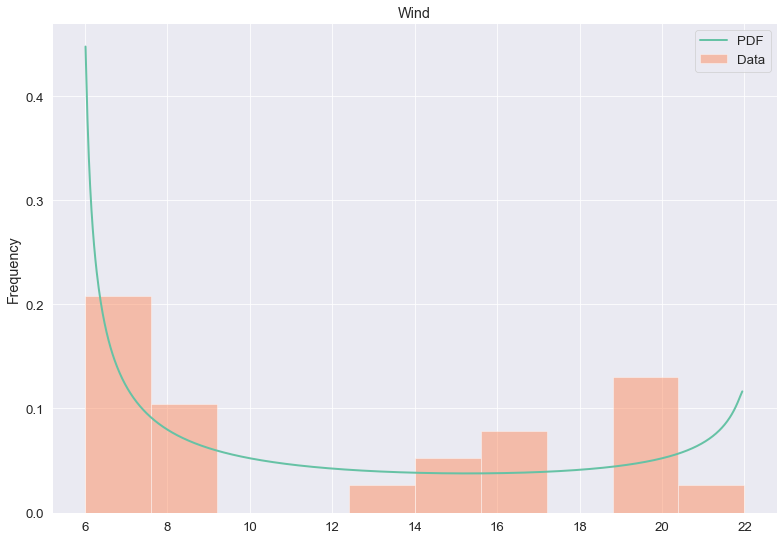

In [43]:
# Plot Wind with johnsonsb distribution fitted.
plot_data_with_pdf_fitted("Wind", johnsonsb)

<br>

* __Wind Direction__

To fit distribution for Wind direction, which is a categorical variable, we would need to convert it first into numerical form. One way of doing this is by representing each wind direction with a label. [19]

> [19] [Dataquest: Add a Column to a Pandas DataFrame Based on an If-Else Condition](https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/)

In [44]:
# Create a list of conditions.
conditions = [
    (df["Wind Direction"] == "west"),
    (df["Wind Direction"] == "north west"),
    (df["Wind Direction"] == "north east"),
    (df["Wind Direction"] == "north")
    ]

# Create a list of the labels.
labels = [1, 2, 3, 4]

# Create a new column and assign labels to it.
df['Wind Label'] = np.select(conditions, labels)

# Display updated DataFrame.
df.head()

,AQI,NO2,PM2.5,PM10,O3,SO2,Wind,Wind Direction,Wind Label
2020-12-07 00:00:00,84,32.1,28.0,36.0,1.0,5.0,9,west,1
2020-12-07 01:00:00,74,29.7,23.0,33.0,0.4,4.2,9,west,1
2020-12-07 02:00:00,74,28.5,23.0,28.1,0.8,4.1,9,west,1
2020-12-07 03:00:00,72,26.9,22.1,21.2,0.4,3.9,7,north west,2
2020-12-07 04:00:00,72,26.1,22.2,21.5,0.3,3.7,7,north west,2


In [45]:
%%capture --no-stdout

# Fit distributions to Wind labels.
fit_dist("Wind Label")

logistic: statistic=0.24142820449267516, pvalue=0.10243491000832372
hypsecant: statistic=0.2491736529357969, pvalue=0.08461505104471723
t: statistic=0.2654720429661786, pvalue=0.055452111141880756
vonmises_line: statistic=0.2690613481454875, pvalue=0.05033544238449639
maxwell: statistic=0.275122865906662, pvalue=0.04261170960125449


In [46]:
# Import logistic distribution.
from scipy.stats import logistic

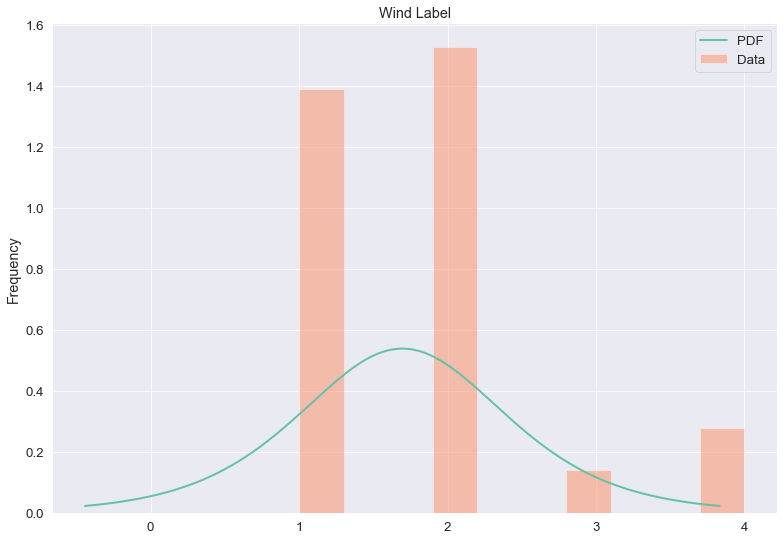

In [47]:
# Plot Wind labels with cauchy distribution fitted.
plot_data_with_pdf_fitted("Wind Label", logistic)

<br>

### Data Simulation <a name="data_simulation"></a>
___

<br>

Now that we know what distributions fit our variables best, we can draw samples for each variable. [20] 

Data is simulated for 56 days, or 1344 hours, till the end of winter counting from 07/12/2020 inclusively.


> [20] [Kite: How to convert a 2D NumPy array to a 1D array in Python](https://www.kite.com/python/answers/how-to-convert-a-2d-numpy-array-to-a-1d-array-in-python)

<br>

* __NO2__

In [48]:
# Drawing samples from pearson3 distribution.
# Create an empty list.
val_sim = []

# Draw samples 56 times
n = 56

# Loop through to add 24 samples in each iteration.
for i in range(n):
    # Get parameters.
    a, loc, scale = pearson3.fit(df["NO2"])
    # Draw samples.
    day_val = pearson3.rvs(a, scale = scale, loc=loc, size = 24)
    val_sim.append(day_val)

# Convert into 1D array.
no2_s = np.array(val_sim).flatten()

<br>

* __PM10, SO2, O3, Wind__

In [49]:
def draw_val_johnson(data, distr):
    """ Drawing samples from johnsonsb and johnsonsu distributions """
    val_sim = []
    for i in range(n):
        # Get parameters.
        a,b, loc, scale = distr.fit(df[data])
        # Draw samples.
        day_val = distr.rvs(a, b, scale = scale, loc=loc, size = 24)
        val_sim.append(day_val)
    return val_sim

In [50]:
# Draw samples for Wind, SO2, PM10, O3.
wind_s = draw_val_johnson("Wind", johnsonsb)
so2_s = draw_val_johnson("SO2", johnsonsb)
pm10_s = draw_val_johnson("PM10", johnsonsb)
o3_s = draw_val_johnson("O3", johnsonsu)

# Convert into 1D array.
wind_s = np.array(wind_s).flatten()
so2_s = np.array(so2_s).flatten()
pm10_s = np.array(pm10_s).flatten()
o3_s = np.array(o3_s).flatten()

<br>

* __AQI, PM2.5, Wind Direction__

In [51]:
def draw_val_l_l(data, distr):
    """ Drawing samples from laplace and logistic distributions """
    val_sim = []
    for i in range(n):
        # Get parameters.
        loc, scale = distr.fit(df[data])
        # Draw samples.
        day_val = distr.rvs(scale = scale, loc=loc, size = 24)
        val_sim.append(day_val)
    return val_sim

In [52]:
# Draw samples for AQI, PM2.5 and Wind labels.
aqi_s = draw_val_l_l("AQI", laplace)
pm25_s = draw_val_l_l("PM2.5", laplace)
wd_s = draw_val_l_l("Wind Label", logistic)

# Convert into 1D array.
aqi_s = np.array(aqi_s).flatten()
pm25_s = np.array(pm25_s).flatten()
wd_s = np.array(wd_s).flatten()

<br> 

* __Time__

In [53]:
# Simulate the date range for 1344 hours.
rng_s = pd.date_range('12/07/2020', periods=1344, freq='H')

<br>

### Simulated Data Set <a name="new_ds"></a>
___

<br>

The next step is to gather all simulated data and create a new data set. And since our real data polutants and wind variables are real number with one decimal places, we should round the simulated data set as well.

In [54]:
# Create a Dataframe from simulated values.
simulated_raw = pd.DataFrame({"AQI": aqi_s,
                     "NO2": no2_s,
                     "PM10": pm10_s,
                     "PM2.5": pm25_s,
                     "SO2": so2_s,
                     "O3": o3_s,
                     "Wind": wind_s,
                     "Wind Label": wd_s
                     }, index=rng_s)

# Round to two decimal places.
df_s = np.round(simulated_raw, decimals=1)

# Display the new data set.
df_s.head()

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Label
2020-12-07 00:00:00,75.3,51.7,28.1,22.6,3.4,0.5,11.8,1.6
2020-12-07 01:00:00,73.7,25.1,34.5,23.2,4.6,0.9,8.0,3.6
2020-12-07 02:00:00,74.5,36.2,23.3,23.8,5.9,0.6,19.9,2.9
2020-12-07 03:00:00,71.2,47.0,28.1,22.7,4.1,1.1,6.1,0.9
2020-12-07 04:00:00,75.6,43.0,19.7,24.6,5.3,3.1,11.2,0.7


As our data for pollution and wind speed must be non-negative, we would need to check if this condition is satisfied. [21]

> [21] [Stack Overflow: Python Pandas: DataFrame filter negative values](https://stackoverflow.com/questions/24214941/python-pandas-dataframe-filter-negative-values)

In [55]:
# Check for negative values.
(df_s >=  0).all()

AQI            True
NO2            True
PM10           True
PM2.5          True
SO2            True
O3            False
Wind           True
Wind Label    False
dtype: bool

Occasionally simulated O3 and Wind Labels appear to have negative values. 

First let's correct this issue for O3 values by converting it to absolute values. [22]

> [22] [Stack Overflow: Python numpy.random.normal only positive values](https://stackoverflow.com/questions/16312006/python-numpy-random-normal-only-positive-values)

In [56]:
# Get an absolute value for each O3 value.
df_s['O3'] = df_s["O3"].abs()

<br>

Now to Wind Labels. We can apply the same method we used when converting the categorical values of Wind Direction to Wind Labels.

In [57]:
# Create a list of conditions.
conditions = [
    (df_s["Wind Label"] <= 1.5),
    (df_s["Wind Label"] > 1.5) & (df_s["Wind Label"] <= 2.5),
    (df_s["Wind Label"] > 2.5) & (df_s["Wind Label"] <= 3.5),
    (df_s["Wind Label"] > 3.5)
    ]

# Create a list of the Wind labels (as originally 4).
new_labels = [1, 2, 3, 4]

# Create a new column and assign directions to it.
df_s['Wind Label'] = np.select(conditions, new_labels)

# Check for negative values again.
(df_s >=  0).all()

AQI           True
NO2           True
PM10          True
PM2.5         True
SO2           True
O3            True
Wind          True
Wind Label    True
dtype: bool

<br>

### Comparison of Simulated and Original data sets <a name="comparison"></a>
___

<br>

Now we can compare the simulated data set with the original by first taking a sample of our data set for 7th December (the same date as in our original data set).

In [58]:
# Select 7th December in the simulated data set.
df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"]

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Label
2020-12-07 00:00:00,75.3,51.7,28.1,22.6,3.4,0.5,11.8,2
2020-12-07 01:00:00,73.7,25.1,34.5,23.2,4.6,0.9,8.0,4
2020-12-07 02:00:00,74.5,36.2,23.3,23.8,5.9,0.6,19.9,3
2020-12-07 03:00:00,71.2,47.0,28.1,22.7,4.1,1.1,6.1,1
2020-12-07 04:00:00,75.6,43.0,19.7,24.6,5.3,3.1,11.2,1
2020-12-07 05:00:00,75.3,38.4,14.8,22.5,3.7,0.6,19.2,1
2020-12-07 06:00:00,76.4,35.0,31.0,24.3,9.0,1.3,14.6,2
2020-12-07 07:00:00,74.8,28.7,30.2,22.9,6.6,1.3,7.5,1
2020-12-07 08:00:00,76.8,34.3,35.5,24.1,5.1,0.2,9.3,1
2020-12-07 09:00:00,73.4,20.7,26.9,25.2,3.4,1.8,7.2,2


<br>

#### Visualization <a name="vis"></a>

Now we can build separate plots for each variable from the data sets. Comparison will be built on the sample taken above and the whole silmulated data set. [23]

> [23] [Stack Overflow: Drawing average line in histogram (matplotlib)](https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib)

<br> 

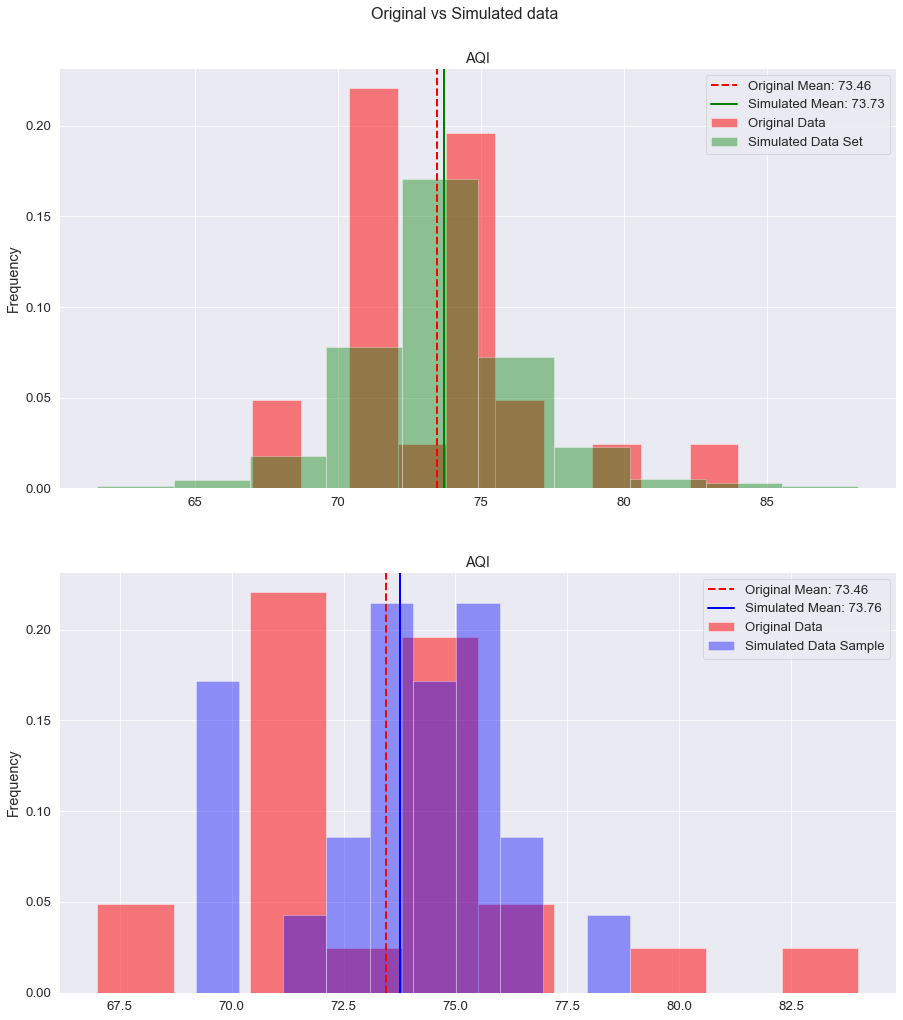

In [59]:
def compare_plots(data):
    ''' Function for plotting original data'''
    fig.suptitle("Original vs Simulated data", y=0.93, fontsize=16)
    # Build plot for original data on ax1.
    df[data].plot(kind='hist', density=True, title=data, alpha=0.5, label='Original Data', color="Red", legend=True, ax=ax1)
    # Plot mean.
    ax1.axvline(df[data].mean(), label =f'Original Mean: {df[data].mean():.2f}', color='r', linestyle='dashed', linewidth=2)
    
    # Same for simulated data set.              
    df_s[data].plot(kind='hist', title=data, density=True, alpha=0.4, label='Simulated Data Set', color="Green", legend=True, ax=ax1)
    ax1.axvline(df_s[data].mean(), label=f'Simulated Mean: {df_s[data].mean():.2f}', color='g', linewidth=2)
    ax1.legend()
     
    # Build plot for original data on ax2.
    df[data].plot(kind='hist', density=True, title=data, alpha=0.5, label='Original Data', color="Red", legend=True, ax=ax2)
    ax2.axvline(df[data].mean(), label =f'Original Mean: {df[data].mean():.2f}', color='r', linestyle='dashed', linewidth=2)
               
    # Same for a simulated sample.
    df_s["2020-12-07 00:00:00": "2020-12-07 23:00:00"][data].plot(kind='hist', title=data, density=True, alpha=0.4, label='Simulated Data Sample', color="Blue", legend=True, ax=ax2) 
    ax2.axvline(df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][data].mean(), label=f'Simulated Mean: {df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][data].mean():.2f}',color='b', linewidth=2)
    ax2.legend()
                
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot AQI.
compare_plots("AQI")

# Show the plot.
plt.show()

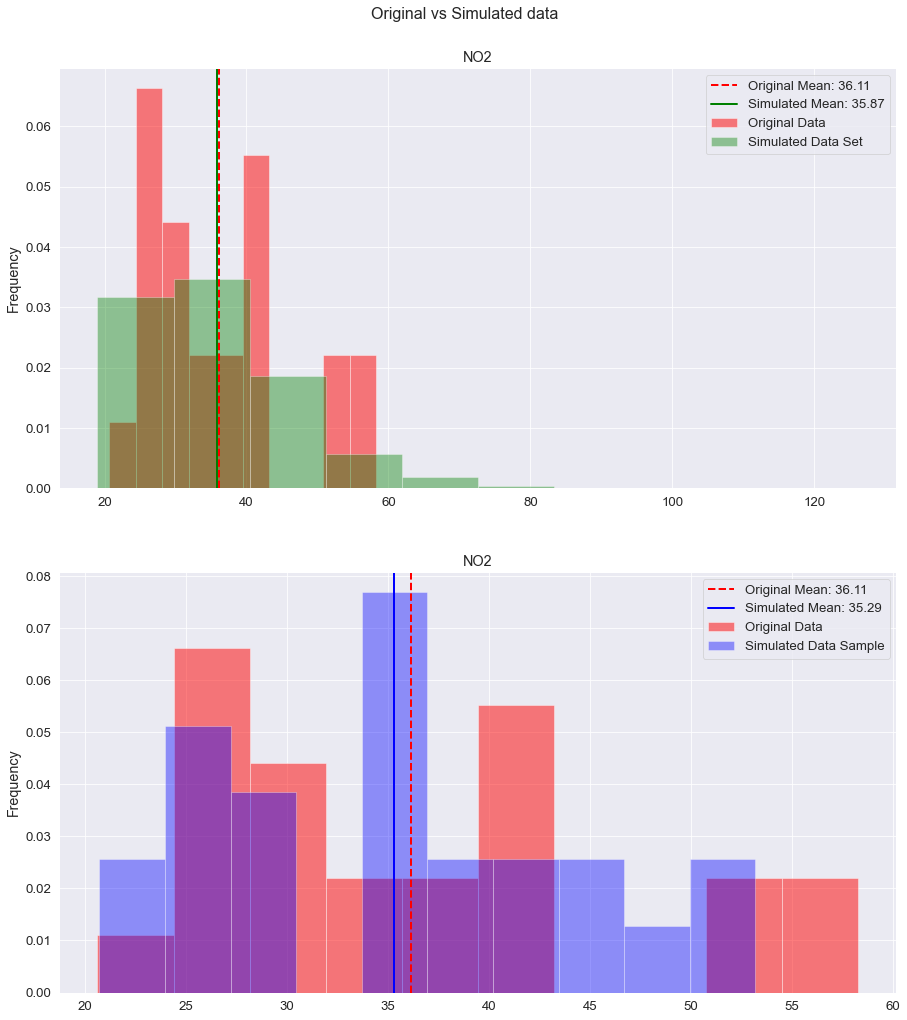

In [60]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot NO2.
compare_plots('NO2')

# Show the plot.
plt.show()

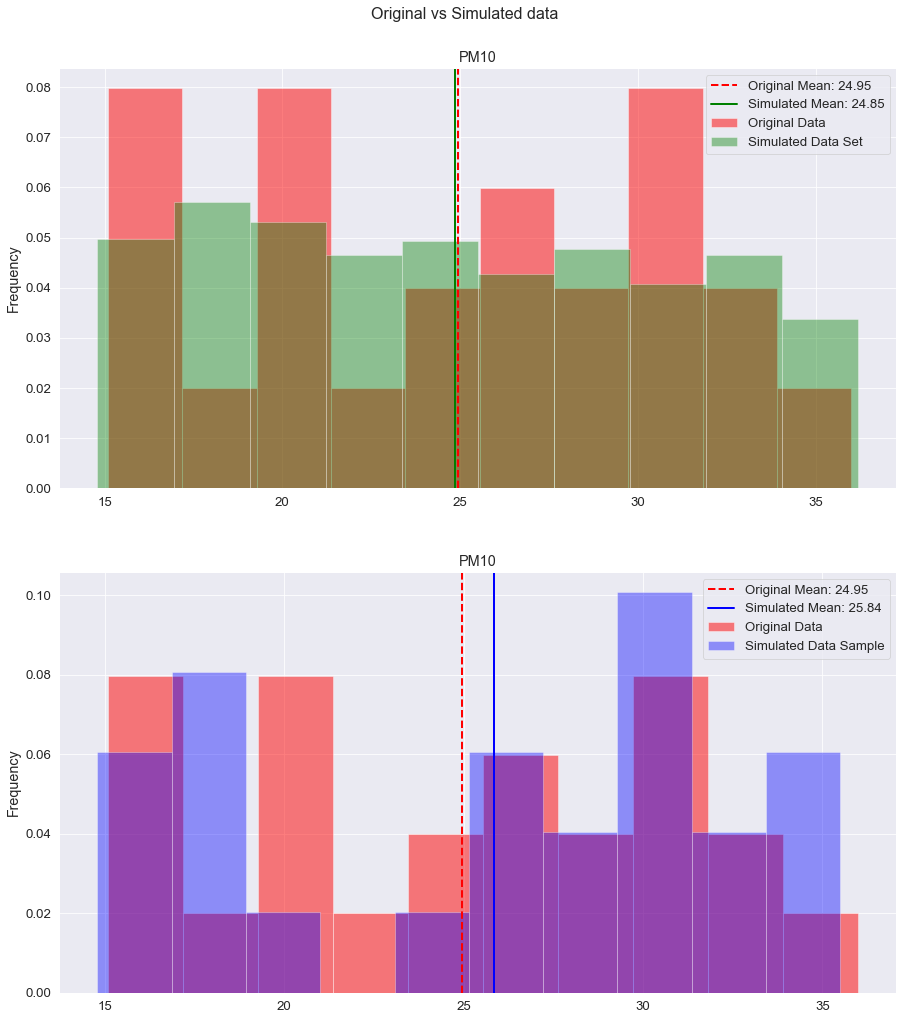

In [61]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot PM10.
compare_plots('PM10')

# Show the plot.
plt.show()

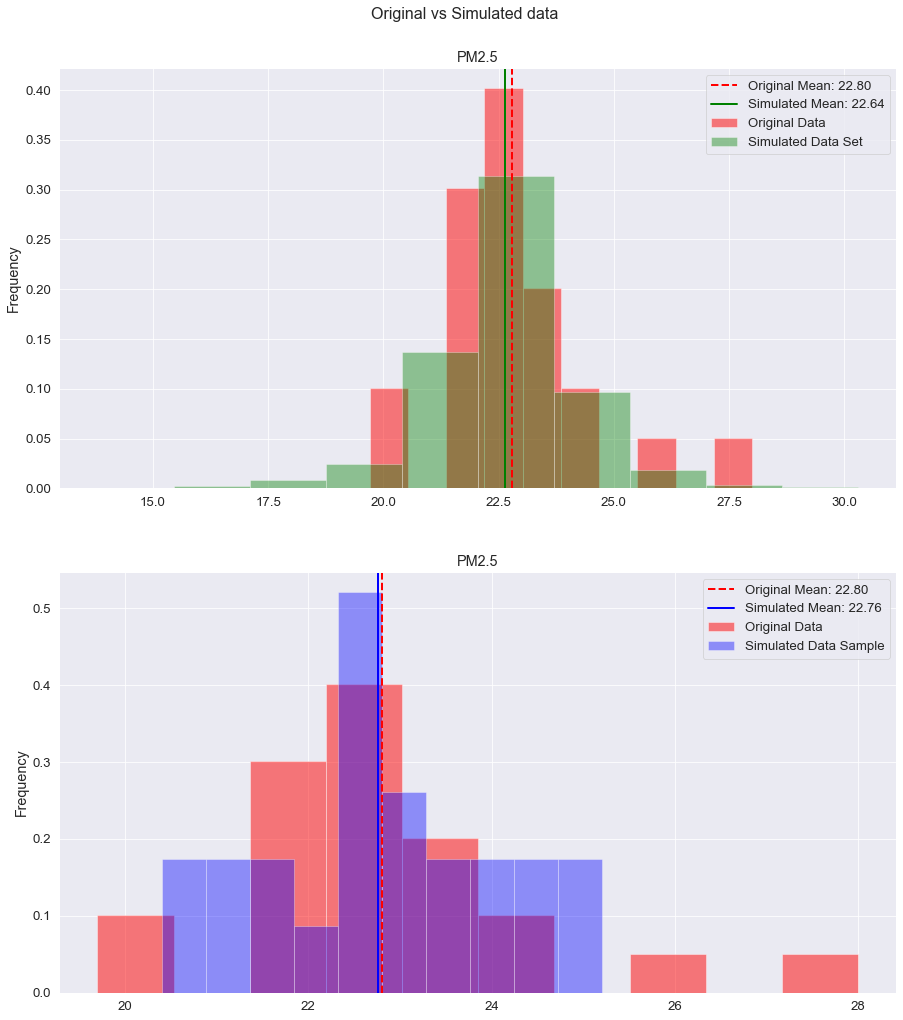

In [62]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot PM2.5.
compare_plots('PM2.5')

# Show the plot.
plt.show()

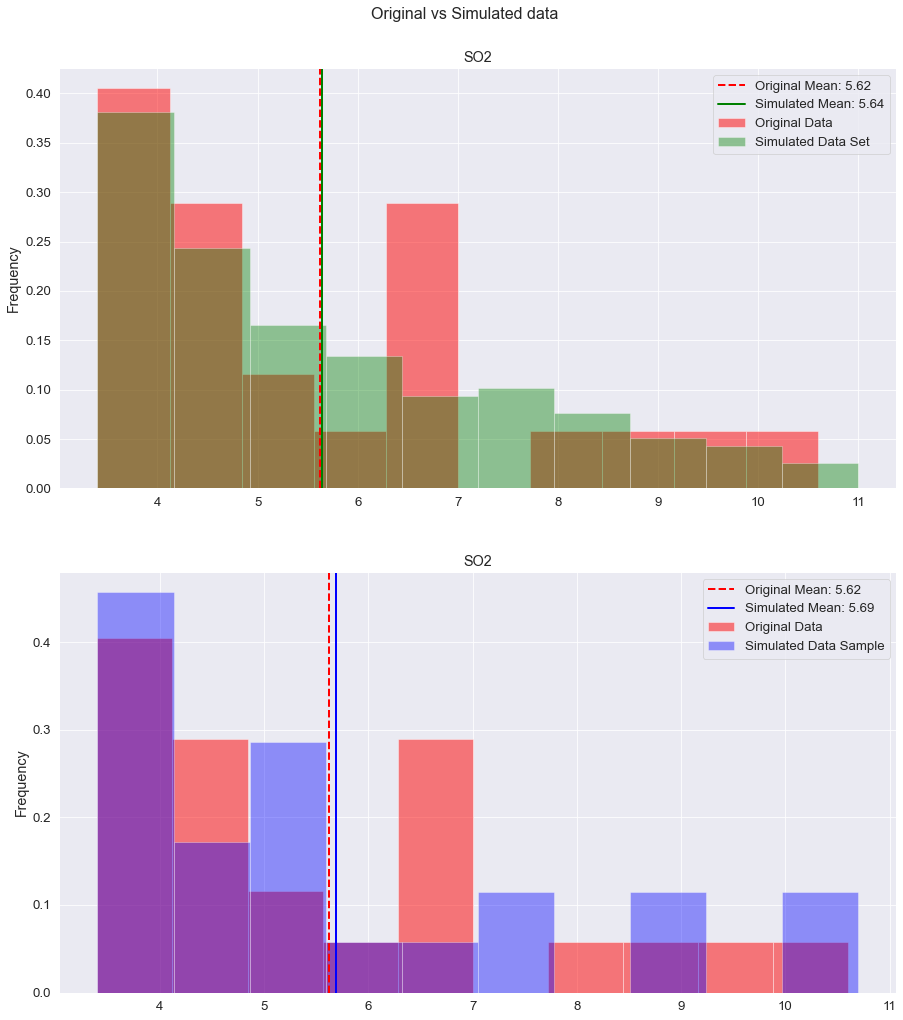

In [63]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot SO2.
compare_plots('SO2')

# Show the plot.
plt.show()

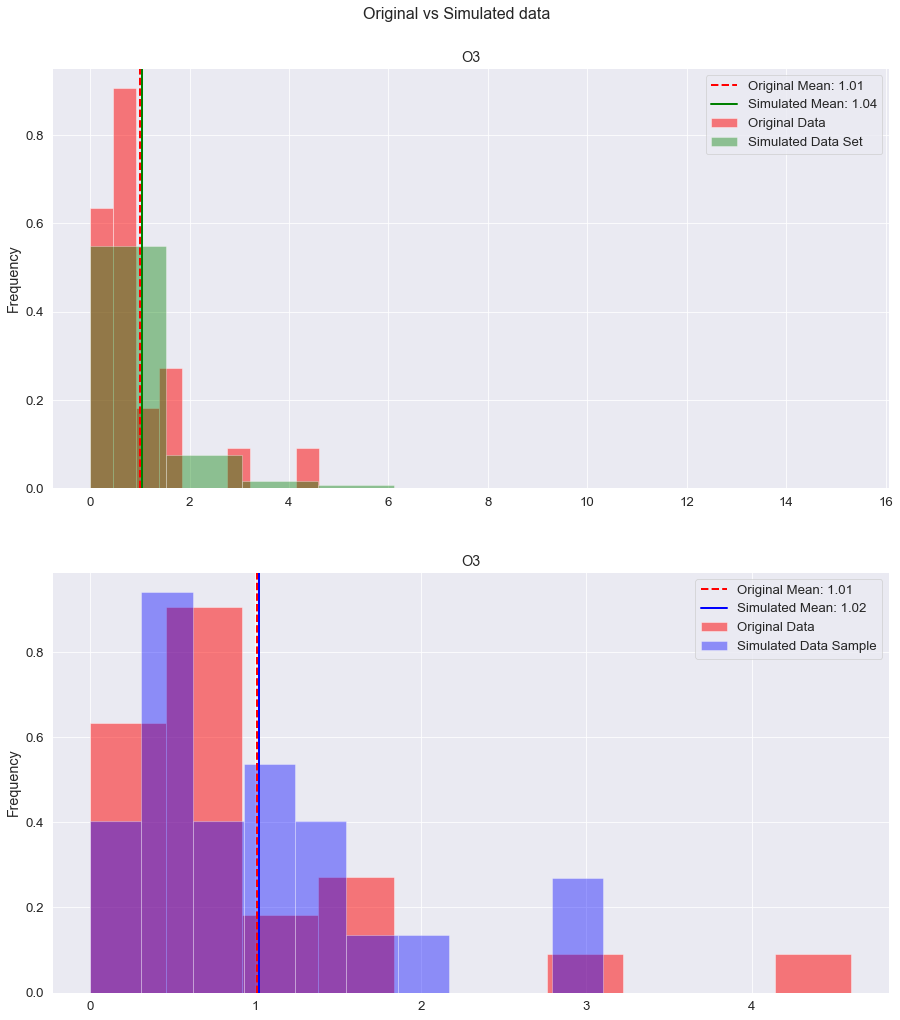

In [64]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot O3.
compare_plots('O3')

# Show the plots.
plt.show()

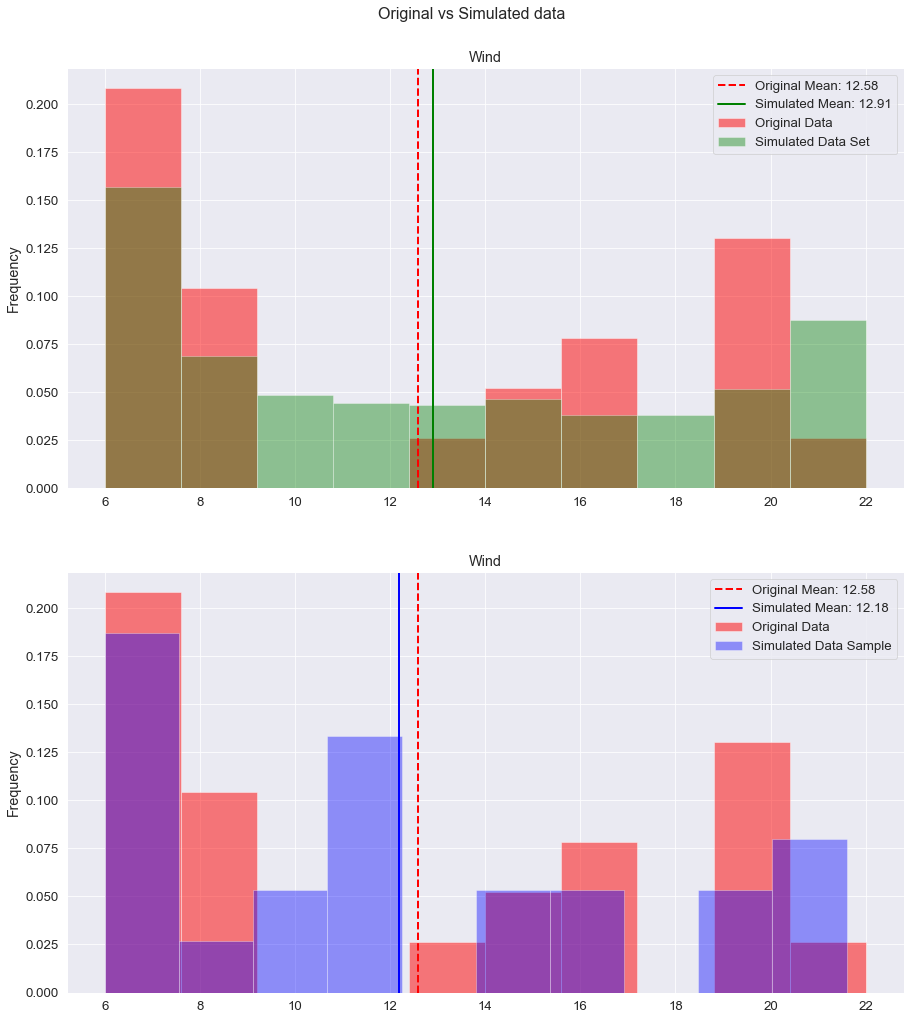

In [65]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot Wind.
compare_plots("Wind")

# Show the plot.
plt.show()

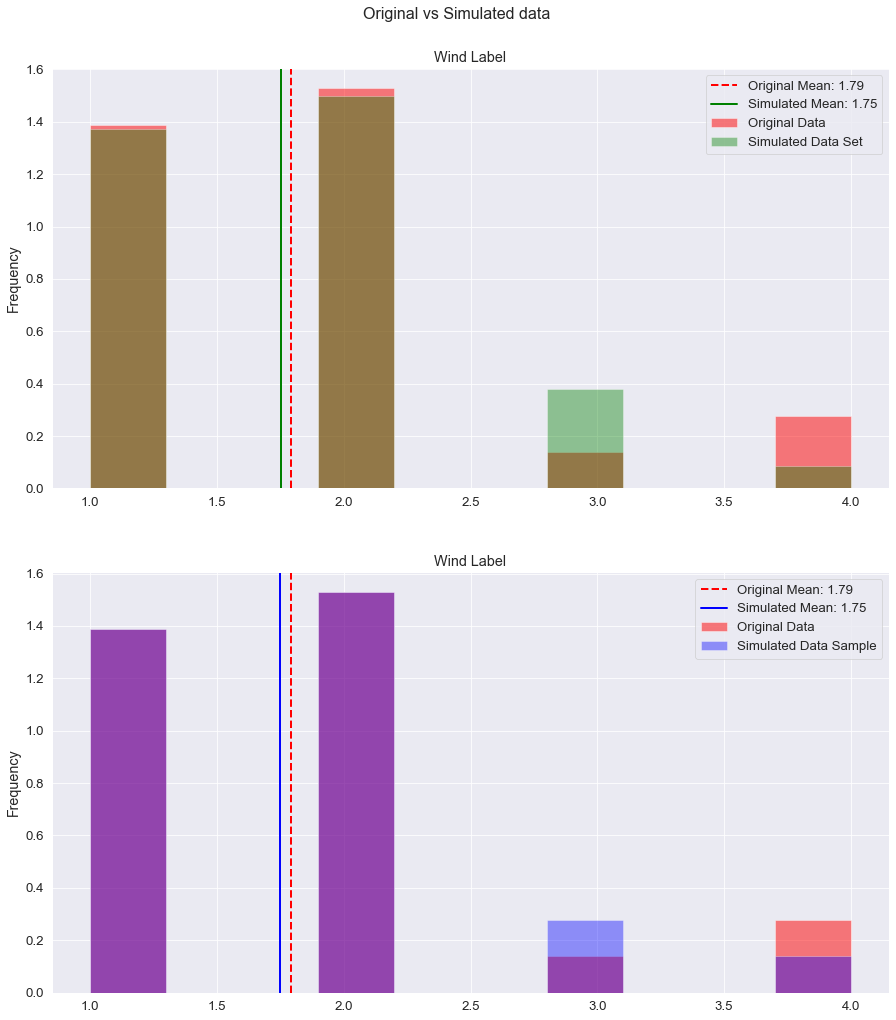

In [66]:
# Create a figure and axis.
fig, [ax1, ax2] = plt.subplots(2,1, figsize=(15, 17))

# Plot Wind Label.
compare_plots("Wind Label")

# Show the plot.
plt.show()

The above plots illustrate that our simulated data is well matched but not ideal. Looking at mean values, we can see that the simulated data set as a whole has its means closer to the original data set than when compared as a sample.

<br>

#### T-test <a name="ttest"></a>

<br>

To compare means we can perform an _independent T-test_ to determine whether there is a statistically significant difference between the means in our data sets. But prior to this, we need to determine if our original set and the sample of simulated data have similar or different variance.

In [67]:
print(f"Original:\n{np.var(df)}")
print(f'\nSimulated:\n{np.var(df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"])}')

Original:
AQI            10.998264
NO2           105.809427
PM2.5           2.601667
PM10           35.104167
O3              0.966597
SO2             3.739983
Wind           28.243056
Wind Label      0.748264
dtype: float64

Simulated:
AQI            5.732431
NO2           80.886094
PM10          44.329097
PM2.5          1.669010
SO2            4.435764
O3             0.568316
Wind          26.726649
Wind Label     0.604167
dtype: float64


We can see that the variance of compared data are different. Thus, when performing a T-test we should opt for Welch’s T-test, which does not assume equal population variance.

In [68]:
# Loop through each numerical column.
for i in df_s.columns:
    # Perform t-test.
    t_ss, p_ss = stats.ttest_ind(df[i], df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][i], equal_var=False)
    # Print results.
    print(f"{i}'s P_value: {p_ss:0.2f}")

AQI's P_value: 0.73
NO2's P_value: 0.77
PM10's P_value: 0.63
PM2.5's P_value: 0.93
SO2's P_value: 0.91
O3's P_value: 0.96
Wind's P_value: 0.79
Wind Label's P_value: 0.86


As all p_values are above 0.05 we can can reject the null hypotesis and conclude that means of all groups are not different (p-value 1 indicates identical means in the data sets). However, we should check for Type II errors, False Negatives, before judging the validity of our results.

In [69]:
# Check for False Negatives.
trials = 10000
dont = 0
critical = 0.05

# Loop through each numerical column.
for i in df_s.columns:
    for j in range(trials):
        if stats.ttest_ind(df[i], df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][i],equal_var=False)[1] <= critical:
            dont = dont + j
    # Calculate false negatives.
    typeii = 100.0 * (dont / trials)
    # Print results.
    print(f"{i} : {typeii:0.2f}%")

AQI : 0.00%
NO2 : 0.00%
PM10 : 0.00%
PM2.5 : 0.00%
SO2 : 0.00%
O3 : 0.00%
Wind : 0.00%
Wind Label : 0.00%


It appears that there are no Type II errors in our calculations; thus, we can confirm the t-test results.

<br>

#### Entropy <a name="entropy"></a>

<br>

Although we have performed The Goodness of Fit earlier when we searched for the best fitting distribution, we can also discover the _Kullback–Leibler divergence_ between the distributions of each variable. KL divergence is considered to be a distance metric (although it is not symmetric) that quantifies the difference between two probability distributions. [24]

[24] [Kullback-Leibler (KL) Divergence and Jensen-Shannon Divergence](https://yongchaohuang.github.io/2020-07-08-kl-divergence/)

In [70]:
kl_div = []

# Perform KL divergence for each variable.
for i in df_s.columns:
    entropy = stats.entropy(df[i], df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][i])
    # Print results.
    print(f'{i}: {stats.entropy(df[i], df_s.loc["2020-12-07 00:00:00": "2020-12-07 23:00:00"][i])}')
    kl_div.append(entropy)

AQI: 0.0012569716934657275
NO2: 0.07998912100069835
PM10: 0.057100520534478526
PM2.5: 0.004283324907137398
SO2: 0.12140107925939958
O3: inf
Wind: 0.11835428274139409
Wind Label: 0.2827438381860609


Despite having medium to high entropy for O3 (or infinity in case of zero values), the rest of the variables present low values. On average the entropy here is an indicator of the closeness of our simulated data set to the original real data.

<br>

### Final adjustments <a name="adj"></a>
___

<br>

Lastly, we can revert Wind labels to their categorical values. The working assumption here is that there are only _west, north west, north east and north_ wind directions during winter in Dublin.

In [71]:
# Create a list of conditions.
conditions = [
    (df_s["Wind Label"] == 1),
    (df_s["Wind Label"] == 2),
    (df_s["Wind Label"] == 3),
    (df_s["Wind Label"] == 4)
    ]

# Create a list of the Wind directions.
directions = ["west", "north west", "north east", "north"]

# Create a new column and assign directions to it.
df_s['Wind Direction'] = np.select(conditions, directions)

# Drop column Wind Label.
simulated_ds = df_s.drop(["Wind Label"],axis=1)

# Display updated DataFrame.
simulated_ds

,AQI,NO2,PM10,PM2.5,SO2,O3,Wind,Wind Direction
2020-12-07 00:00:00,75.3,51.7,28.1,22.6,3.4,0.5,11.8,north west
2020-12-07 01:00:00,73.7,25.1,34.5,23.2,4.6,0.9,8.0,north
2020-12-07 02:00:00,74.5,36.2,23.3,23.8,5.9,0.6,19.9,north east
2020-12-07 03:00:00,71.2,47.0,28.1,22.7,4.1,1.1,6.1,west
2020-12-07 04:00:00,75.6,43.0,19.7,24.6,5.3,3.1,11.2,west
...,...,...,...,...,...,...,...,...
2021-01-31 19:00:00,70.5,48.5,34.8,23.0,6.9,1.8,12.5,north east
2021-01-31 20:00:00,64.9,35.0,18.6,22.3,8.6,0.9,15.5,west
2021-01-31 21:00:00,72.1,29.2,22.1,23.7,7.2,0.8,6.0,north west
2021-01-31 22:00:00,73.0,31.0,24.6,22.2,6.0,0.3,17.6,north


<br>

___

### End